# Tutorial III: Fully connected NNs

<p>
Bern Winter School on Machine Learning, 2024<br>
Prepared by Mykhailo Vladymyrov and Matthew Vowels.
</p>

This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

In this session we will create a fully-connected neural network to perform handwritten digit recognition using pytorch

## 1. Load necessary libraries



In [2]:
import os
import sys
import tarfile
import requests

import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#!pip install torchvision
from torchvision import datasets, transforms
import torch.utils.data
from torch.utils.data import TensorDataset, DataLoader



# URL of the file to download
#url = 'https://github.com/neworldemancer/BMLWS/raw/main/tut_files/tpub0320.tgz'

# Path where the file will be saved
#path = os.path.abspath('.') + '/material.tgz'

# Download the file
#response = requests.get(url)
#assert response.status_code == 200, "Download failed"
#with open(path, 'wb') as file:
#    file.write(response.content)

# Check if the path is correct
#assert os.path.exists(path), "File not found"

# Extract the tar file
#tar = tarfile.open(path, "r:gz")
#tar.extractall()
#tar.close()

  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/3b/0a/59f82c490e82c3f3671deb374b1d53e3285ff91b76cae46f99b5b3c3e2d7/torchvision-0.16.2-cp311-cp311-macosx_10_13_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.1 MB/s eta 0:00:0000:0100:010m


## 2. Training loop

The training as we just saw is done iteratively, by adjusting the model parameters.

We perform optimization several times for all traininng dataset. Going through all this dataset is refered to as 'epoch'.

When we do training its usually done in two loops. In outer loop we iterate over all epochs. For each epoch we usually split the dataset into small chuncks, batches, and optimization it performed for all of those.

It is important that data doesn't go to the training pipeline in same order. So the overall scheme looks like this (pseudocode):


```
x,y = get_training_data()
for epoch in range(number_epochs):
   x_shfl,y_shfl = shuffle(x,y)
   
   for mb_idx in range(number_minibatches_in_batch):
       x_mb,y_mb = get_minibatch(x_shfl,y_shfl, mb_idx)
       
       optimize_on(data=x_mb, labels=y_mb)
```

## 3. Bulding blocks of a neural network

Neural network consists of layers of neurons. 

Each neuron performs 2 operations.

1. Calculate the linear transformation of the input vector $\mathbf{x}_i$:

$$\mathbf{z}_i = \mathbf{w} \cdot \mathbf{x}_i + b = \sum_j {w_j x_{ij}} + b$$ 

where $\mathbf{w}$ is a weight vector and $b$ a bias, and $j$ traverses each dimension of the input vector

2. Perform the nonlinear transformation of the result using the activation function $f$ $$y_i = f(z_i)$$

In a fully connected neural network, each layer is a set of N neurons, performing different transformations of the input $\mathbf{x}_i$ of the same layer, now producing an output **vector** $ \mathbf{y} _i = f(\mathbf{z}_i) = f(W\mathbf{x}_i + \mathbf{b})$ with a bias vector $\mathbf{b}$ and a **matrix** of weights $W$.

Since the output of each layer constitutes the input to the next layer, we can write for layer $l$: $$\mathbf{x}^l_i = f^{l-1}(\mathbf{W}^{ l-1} \mathbf{x}^{ l-1}_i + \mathbf{b}^{l-1})$$ where $\mathbf{x}_i^{l=0}$ is the vector d 'network input for data point $i$.



<img src="https://github.com/neworldemancer/BMLWS/raw/main/figures/MLP.png" alt="drawing" width="50%"/>

To simplify building the network, we'll define a helper function, creating neuron layer with given number of outputs:

In [3]:

class Dense(nn.Module):
    def __init__(self, units, activation=None):
        """
        Fully connected layer.

        Parameters
        ----------
        units : int
            Number of output neurons
        activation : None or callable, optional
            Non-linear activation function (e.g., torch.nn.functional.relu)
        """
        super(Dense, self).__init__()
        self.units = units
        self.activation = activation

        # Initialize the weights and biases
        self.linear = nn.Linear(in_features=units, out_features=units)

    def forward(self, inputs):
        # Apply linear transformation
        outputs = self.linear(inputs)

        # Apply activation function if provided
        if self.activation is not None:
            outputs = self.activation(outputs)

        return outputs


In the case of multi-class classification, in the last layer, we can use the *softmax* transformation as a non-linear transformation. The softmax for the $j$th element of $\mathbf{z}_i$ is $$y_{ij} = \frac{e^{z_{ij}}}{\sum_{k=1}^{K} e^{z_{ik}}}$$ where $K$ is the total number of classes.


For example. before softmax $$[1.0, 2.0, 3.0, \mathbf{4.0} ]$$ and after: $$[0.0321, 0.0871, 0.2369, \mathbf{0.6439}]$$ (now the sum is equal to one)

We can also now compare the fundamental truth which could be $$[0,0,0,\mathbf{1}]$$ That is to say that class 4 is the good class and that the network predicted correctly.



The **optimization/loss function** in multiclass classification problems is multiclass cross-entropy:

$$\mathcal{L}_i = - \sum_{k=1}^K y^*_{ik} \log(y_{ik})$$ 

where $y^*_{ik}$ is the *kth* component of the unique true label vector $\mathbf{y}^*_i$, and $y_{ik}$ is the *kth* component of the predicted probability vector $\mathbf{y}_i$.

$$[0.0321, 0.0871, 0.2369, \mathbf{0.6439}] = [y_{i1}, y_{i2}, y_{i3}, y_{i4}]$$

## 4. Structure of a neural network

In [49]:
class MyModel(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(MyModel, self).__init__()
        # Layer 1: 10 inputs -> 4, with sigmoid activation
        self.l1 = nn.Linear(n_input, n_hidden)

        # Layer 2: 4 inputs -> n_output, with softmax activation
        self.l2 = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        # Apply first layer and sigmoid activation
        x = torch.sigmoid(self.l1(x))

        # Apply second layer
        l2_output = self.l2(x)

        # Apply softmax activation
        l2_softmax = F.softmax(l2_output, dim=1)

        # Prediction: argmax for classification
        pred = torch.argmax(l2_softmax, dim=1)

        return l2_softmax, pred

## 5. Load the data

First we will load the data: 60000 training images and 10000 images for validation with some included data transformations.

Each image is a 28x28 pixels. For this model we will interpret it as a 1D array of 784 elements.

In [50]:
# Define a transform to normalize the data:
# Transforms to a tensor first
# Normalises values second
# Flattens image next
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                                transforms.Lambda(lambda x: torch.flatten(x))])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

# Print shapes of the datasets
print('Train dataset shape:', len(trainset), 'total images and labels')
print('Test dataset shape:', len(testset), 'total images and labels')

Train dataset shape: 60000 total images and labels
Test dataset shape: 10000 total images and labels


In [51]:
#Inspecting the trainset
for el in trainset:
    x,y = el
    print(x.shape, y)
    break

torch.Size([784]) 5


In [52]:
#Inspecting the trainset
for el in trainloader:
    x,y = el
    print(x.shape, y.shape)
    break

torch.Size([64, 784]) torch.Size([64])


 Let's take a look at some of the example images

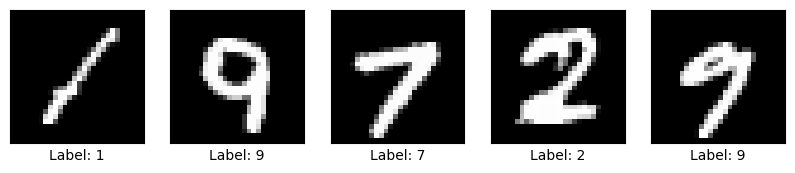

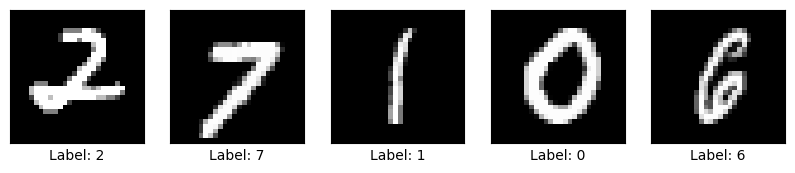

In [53]:
def show_images(images, labels, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        # Reshape the flattened images back to 28x28 for display
        plt.imshow(images[i].numpy().reshape(28, 28), cmap='gray')
        plt.xlabel('Label: {}'.format(labels[i].item()))
    plt.show()

# Function to get random images and labels from a dataset
def get_random_images(loader, num_images=5):
    dataiter = iter(loader)
    images, labels = next(dataiter)
    indices = list(range(len(images)))
    random_indices = random.sample(indices, num_images)
    random_images = images[random_indices]
    random_labels = labels[random_indices]
    return random_images, random_labels

# Get random images and labels from the training set
random_images, random_labels = get_random_images(trainloader, num_images=5)
# Show images
show_images(random_images, random_labels, num_images=5)

# and for the test set:
random_images, random_labels = get_random_images(testloader, num_images=5)
show_images(random_images, random_labels, num_images=5)



Check out the dimensions of the data

In [54]:

# Inspect the dimensions of the sample elements
print("Shape of the images:", random_images.shape)
print("Shape of the labels:", random_labels.shape)
print(random_labels)

Shape of the images: torch.Size([5, 784])
Shape of the labels: torch.Size([5])
tensor([2, 7, 1, 0, 6])


## 6. Bulding a neural network

Number of inputs for neurons will be given by input data, i.e. image dims (flattened), size. Output - by number of classes, 10 in our case.

In [60]:
n_hidden = 100
model = MyModel(n_input=784, n_hidden=n_hidden, n_output=10)  # 784 input features for 28x28 images, 10 output classes

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (e.g., Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)


Defining a training function:

In [61]:
def train(model, trainloader, criterion, optimizer):
    """
    Function to train the neural network model on the training dataset.

    Parameters:
    -----------
    model : torch.nn.Module
        The neural network model to be trained.
    trainloader : torch.utils.data.DataLoader
        DataLoader for the training dataset.
    criterion : torch.nn.modules.loss._Loss
        Loss function used for training the model.
    optimizer : torch.optim.Optimizer
        Optimization algorithm for updating the model parameters.

    Returns:
    --------
    float
        Average loss (cost) on the training dataset.
    """

    model.train()               # Set the model to training phase
    running_loss = 0.0          # Initialize a floating-point value for the loss

    for images, labels in trainloader:   # Iterate through the batches in the trainloader
        optimizer.zero_grad()            # Reset gradients
        output, _ = model(images)     # Forward pass through the model
        loss = criterion(output, labels) # Compute the loss
        loss.backward()                  # Compute gradients
        optimizer.step()                 # Update parameters with gradients
        running_loss += loss.item()      # Update the numerical value of the loss

    return running_loss / len(trainloader)  # Output the average loss on the training dataset


Defining a testing function:

In [64]:
def test(model, testloader, criterion):
    """
    Function to evaluate the model on the test dataset.

    Parameters:
    -----------
    model : torch.nn.Module
        The neural network model to be evaluated.
    testloader : torch.utils.data.DataLoader
        DataLoader for the test dataset.
    criterion : torch.nn.modules.loss._Loss
        Loss function used for evaluating the model.

    Returns:
    --------
    float
        Average loss (cost) on the test dataset.
    """
    model.eval()                  # Set the model to evaluation mode
    running_loss = 0.0            # Initialize a floating-point value for the loss
    #n_correct = 0
    with torch.no_grad():         # Disable gradient computation during testing
        for images, labels in testloader:      # Iterate through the batches in the testloader
            output, _ = model(images) # Forward pass through the model
            loss = criterion(output, labels)   # Compute the loss
            running_loss += loss.item()        # Update the numerical value of the loss
            #correct = torch.sum(pred == labels)
            #n_correct =+ correct
    return running_loss / len(testloader)  # Output the average loss on the test dataset

Training the model

In [65]:
# Training the model

num_epochs = 10           # Number of training epochs
train_losses = []         # List to store training losses for each epoch
test_losses = []          # List to store test losses for each epoch

# Training loop
for epoch in range(num_epochs):
    # Train the model on the training dataset and compute the training loss
    train_loss = train(model, trainloader, criterion, optimizer)
    
    # Evaluate the model on the test dataset and compute the test loss
    test_loss = test(model, testloader, criterion)

    # Append the training and test losses to their respective lists
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    # Print the current epoch, training loss, and test loss
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


Epoch 1/10, Train Loss: 1.5525, Test Loss: 1.5365
Epoch 2/10, Train Loss: 1.5335, Test Loss: 1.5290
Epoch 3/10, Train Loss: 1.5226, Test Loss: 1.5183
Epoch 4/10, Train Loss: 1.5148, Test Loss: 1.5165
Epoch 5/10, Train Loss: 1.5094, Test Loss: 1.5162
Epoch 6/10, Train Loss: 1.5048, Test Loss: 1.5104
Epoch 7/10, Train Loss: 1.5015, Test Loss: 1.5040
Epoch 8/10, Train Loss: 1.4982, Test Loss: 1.5050
Epoch 9/10, Train Loss: 1.4957, Test Loss: 1.5036
Epoch 10/10, Train Loss: 1.4930, Test Loss: 1.4986


Visualize the loss curves

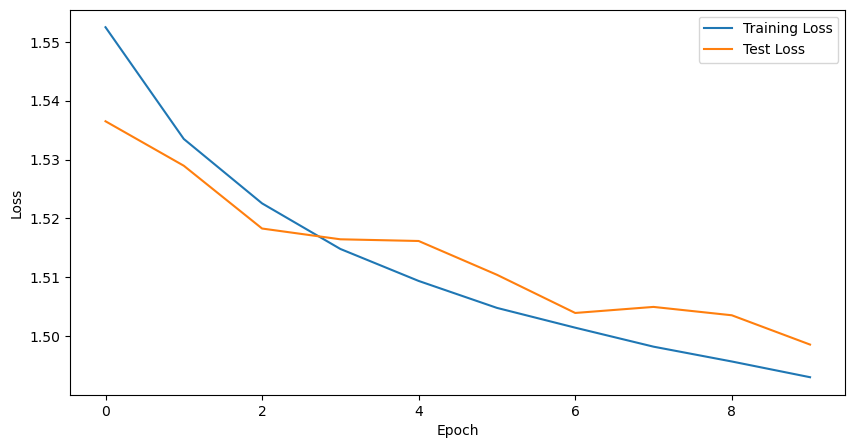

In [66]:
# Plotting the loss curves

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(num_epochs), train_losses, label='Training Loss')
ax.plot(range(num_epochs), test_losses, label='Test Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc='upper right')
plt.show()

Evaluate network performance using a basic accuracy metric:

$$\mathbf{Acc}= \frac{1}{N}\sum_{i=1}^N \mathbb{I}(y_i = y^*_i)$$

where $\mathbb{I}()$ is the indicator function.


Also investigate what an incorrect prediction looks like...

In [67]:
def get_predictions(model, loader):
    """
    Function to obtain predictions, true labels, and input images from a given DataLoader.

    Parameters:
    -----------
    model : torch.nn.Module
        The neural network model used for making predictions.
    loader : torch.utils.data.DataLoader
        DataLoader for the dataset from which predictions, labels, and images are obtained.

    Returns:
    --------
    tuple
        A tuple containing predictions (list), true labels (list), and input images (list).
    """

    model.eval()                   # Set the model to evaluation mode
    predictions = []               # List to store model predictions
    labels = []                    # List to store true labels
    images_list = []               # List to store input images

    with torch.no_grad():          # Disable gradient computation during prediction
        for images, label in loader:  # Iterate through batches in the loader
            output, _ = model(images)     # Forward pass through the model
            pred = output.argmax(dim=1)   # Obtain the predicted class with the highest probability
            predictions.extend(pred.tolist())  # Extend the predictions list
            labels.extend(label.tolist())      # Extend the true labels list
            images_list.extend(images)         # Extend the list of input images

    return predictions, labels, images_list  # Output predictions, true labels, and input images as a tuple


def calculate_accuracy(predictions, labels):
    """
    Function to calculate accuracy given a list of predictions and true labels.

    Parameters:
    -----------
    predictions : list
        List of predicted class labels.
    labels : list
        List of true class labels.

    Returns:
    --------
    float
        Accuracy calculated as the ratio of correctly predicted samples to the total number of samples.
    """

    correct = sum(pred == label for pred, label in zip(predictions, labels))  # Count the correct predictions
    total = len(labels)  # Total number of samples
    accuracy = correct / total  # Calculate accuracy as the ratio of correct predictions to the total

    return accuracy  # Output the calculated accuracy as a float


# Get predictions, labels, and images
predictions, labels, images_list = get_predictions(model, testloader)
correct = [pred == label for pred, label in zip(predictions, labels)]

accuracy = calculate_accuracy(predictions, labels)

print(f"Accuracy: {accuracy}")

Accuracy: 0.9686


Aggregate a correct and incorrect example and visualize:

First incorrect digit is at index: 35


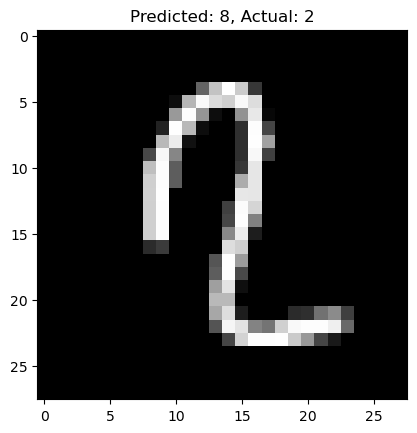

First correct digit is at index: 0


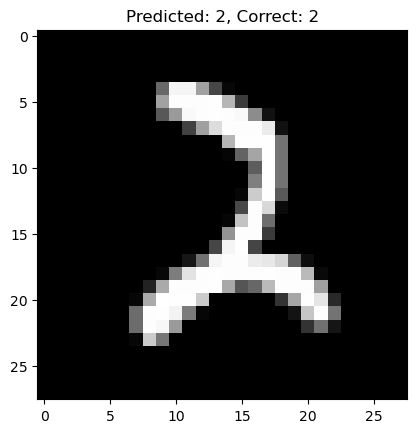

In [68]:

# Find the index of the first incorrect and correct prediction
wrong_idx = next((i for i, correct in enumerate(correct) if not correct), None)
correct_idx = next((i for i, correct in enumerate(correct) if correct), None)

# Function to display an image
def display_image(image, title):
    plt.imshow(image.numpy().reshape(28, 28), cmap='gray')
    plt.title(title)
    plt.show()

# Display the first incorrect digit (if any incorrect are found)
if wrong_idx is not None:
    print(f"First incorrect digit is at index: {wrong_idx}")
    display_image(images_list[wrong_idx], f"Predicted: {predictions[wrong_idx]}, Actual: {labels[wrong_idx]}")
else:
    print("No incorrect predictions found")

# Display the first correct digit (if any correct are found)
if correct_idx is not None:
    print(f"First correct digit is at index: {correct_idx}")
    display_image(images_list[correct_idx], f"Predicted: {predictions[correct_idx]}, Correct: {labels[correct_idx]}")
else:
    print("No correct predictions found")

## 7. Visualizing the Parameters

The learned model parameters W1 are a matrix of weights that show importance of each input pixel (784) for each of the 10 outputs.

In [41]:
w1, b1 = model.l1.weight.data, model.l1.bias.data
print(w1.shape, b1.shape)

torch.Size([100, 784]) torch.Size([100])


torch.Size([100, 784]) torch.Size([100])


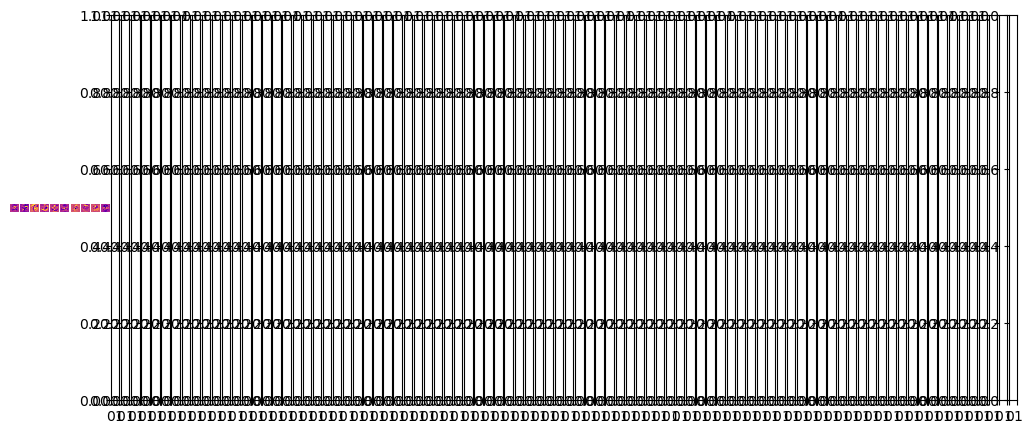

In [40]:
w1_reshaped = w1.view(n_hidden, 28, 28)  # Adjust the view dimensions as per your layer's configuration

# Plotting the weights
_, axs = plt.subplots(1, n_hidden, figsize=(13, 5))
for i in range(10):
    axs[i].imshow(w1_reshaped[i].numpy(), cmap='plasma', interpolation='nearest')
    axs[i].grid(False)
    axs[i].axis('off')
plt.show()

Here we classify images into 10 classes. But think of it: does the network know, or need to know that those were images? For the network each image is just a list of 784 values. And it finds that there is a pattern.

In the same way one can feed any other bunch of numbers, and the network will try its best to figure out a relational pattern between these.

In [31]:
def get_predictions(model, loader):
    model.eval()
    predictions = []
    labels = []
    images_list = []
    with torch.no_grad():
        for images, label in loader:
            output, _ = model(images)
            pred = output.argmax(dim=1)
            predictions.extend(pred.tolist())
            labels.extend(label.tolist())
            images_list.extend(images)
    return predictions, labels, images_list

def calculate_accuracy(predictions, labels):
    correct = sum(pred == label for pred, label in zip(predictions, labels))
    total = len(labels)
    accuracy = correct / total
    return accuracy

In [32]:
predictions, labels, images_list = get_predictions(model, testloader)  # TEST

accuracy = calculate_accuracy(predictions, labels)

print(f"Accuracy: {accuracy}")

Accuracy: 0.9109


## 8. Exercise 1

Build a network with two layers, first with `tf.nn.relu` ReLU activation and 1500 neurons and second one with 10 and softmax activation. Start with `learning_rate` of 0.001 and find optimal value.

## 9. Gradients visualization

We will display several images, and corresponding gradients of maximal output activation, as well as all activations. This might help better understand how our network processes the imput data.

In [ ]:
model.eval()
grads_all_classes = []


# The code uses torch.autograd.grad to compute the gradients of the model's predictions with respect to the input image.
# This essentially answers the question, "How does changing each pixel in the input image affect the model's confidence in its prediction for each class (digit)?"

# For each digit class (0 to 9), the code computes a separate gradient map.
# It does so by setting grad_outputs to a tensor that is all zeros except for a one at the current class's position.
# This way, the computed gradient reflects how much each pixel in the input image contributes to the model's prediction for that specific class.

dataiter = iter(trainloader)
images, labels = next(dataiter)

# Choose an index and select a single image and label
idx = 1
inp_v = images[idx:idx+1]  # Selecting the image
img = inp_v.squeeze()  # The original 2D image for display

# Enable gradients for input
inp_v.requires_grad = True

# Forward pass and compute gradients
model.eval()
with torch.set_grad_enabled(True):
    preds = model(inp_v)[0]  # Assuming the model returns a tuple (output, argmax)
    for i in range(preds.size(1)):  # Iterate over each class
        grad_outputs = torch.zeros_like(preds)
        grad_outputs[0, i] = 1
        grads = torch.autograd.grad(outputs=preds, inputs=inp_v, grad_outputs=grad_outputs, create_graph=True)[0]
        grads_all_classes.append(grads)

# Stack all gradients and reshape to desired format
grads_stacked = torch.stack(grads_all_classes).view(preds.size(1), 28, 28).detach().numpy()



Each of the following subplots shows the gradient map for a particular class. These maps can be interpreted as heatmaps indicating which regions of the input image are most critical for the model's prediction of that particular digit.
Brighter areas in a gradient map indicate pixels that, if changed, would have a larger impact on the model's prediction for that class. This can give insights into what features the model is focusing on for each class.


https://medium.com/geekculture/how-visualizations-help-make-sense-of-deep-learning-a408ab00688f


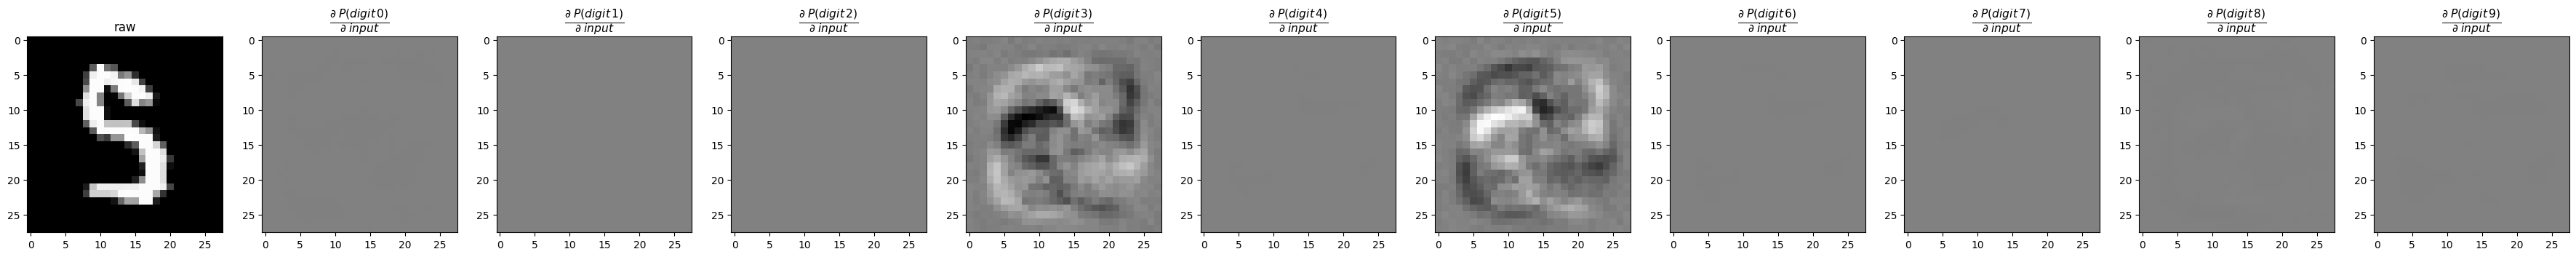

In [ ]:
# Each of the following subplots shows the gradient map for a particular class.
# These maps can be interpreted as heatmaps indicating which regions of the input image are most critical for the model's prediction of that particular digit.
# Brighter areas in a gradient map indicate pixels that, if changed, would have a larger impact on the model's prediction for that class.
# This can give insights into what features the model is focusing on for each class.

# Reshape the flattened image back to 2D for display
img_2d = img.view(28, 28).numpy()

# Plotting
fig, axs = plt.subplots(1, 11, figsize=(4.1 * 11, 4))
axs[0].imshow(img_2d, cmap='gray')  # Display the reshaped original image
axs[0].set_title('raw')
vmin, vmax = grads_stacked.min(), grads_stacked.max()


for i, g in enumerate(grads_stacked):
    axs[i + 1].imshow(g, cmap='gray', vmin=vmin, vmax=vmax)
    axs[i + 1].set_title(r'$\frac{\partial\;P(digit\,%d)}{\partial\;input}$' % i, fontdict={'size': 16})

plt.show()

## 10. Exercise 2

### Group 1
Build the network with 3 or more layers. Try to get test accuracy >98.5%.
Better to copy and modify the previous code so that you can compare against the code/results above.

In [44]:
class MyModel2(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(MyModel2, self).__init__()

        self.ls = []  # List to store the hidden layers
        n_prev = n_input  # Initialize the number of previous neurons to the input size

        # Loop to create hidden layers
        for i, n_out in enumerate(n_hidden):
            # Create a linear layer with the previous and current layer sizes
            l = nn.Linear(n_prev, n_out)
            n_prev = n_out  # Update the number of previous neurons to the current layer size
            self.add_module(f'lin_{i}_{n_out}', l)  # Add the linear layer as a module
            self.ls.append(l)  # Append the linear layer to the list

        # Create the output layer
        self.lout = nn.Linear(n_prev, n_output)

    def forward(self, x):
        h = x  # Initialize h with the input tensor
        for li in self.ls:
            h = li(h)  # Apply linear transformation
            h = torch.relu(h)  # Apply ReLU activation function

        logits = self.lout(h)  # Apply the final linear transformation
        # Apply softmax activation
        probs = F.softmax(logits, dim=1)

        # Prediction: argmax for classification
        pred = torch.argmax(probs, dim=1)

        return logits, probs, pred


In [46]:
n_hidden = [100]
model = MyModel2(n_input=784, n_hidden=n_hidden, n_output=10)  # 784 input features for 28x28 images, 10 output classes

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (e.g., Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)


### Group 2

You can repeat the same for a regression problem: here you will have just 1 output in the last layer, with no activation - to predict continuous unboud range. You can use the `mse` or `mae` loss. Compare results with a baseline linear / random forest model.

How many parameters does your model have as compared to number of samples?

Epoch 1/10, Train Loss: 2.0871, Test Loss: 1.4788
Epoch 2/10, Train Loss: 1.1713, Test Loss: 0.9885
Epoch 3/10, Train Loss: 0.9138, Test Loss: 0.8448
Epoch 4/10, Train Loss: 0.8048, Test Loss: 0.7582
Epoch 5/10, Train Loss: 0.7253, Test Loss: 0.6911
Epoch 6/10, Train Loss: 0.6662, Test Loss: 0.6387
Epoch 7/10, Train Loss: 0.6165, Test Loss: 0.5958
Epoch 8/10, Train Loss: 0.5771, Test Loss: 0.5612
Epoch 9/10, Train Loss: 0.5443, Test Loss: 0.5316
Epoch 10/10, Train Loss: 0.5162, Test Loss: 0.5071


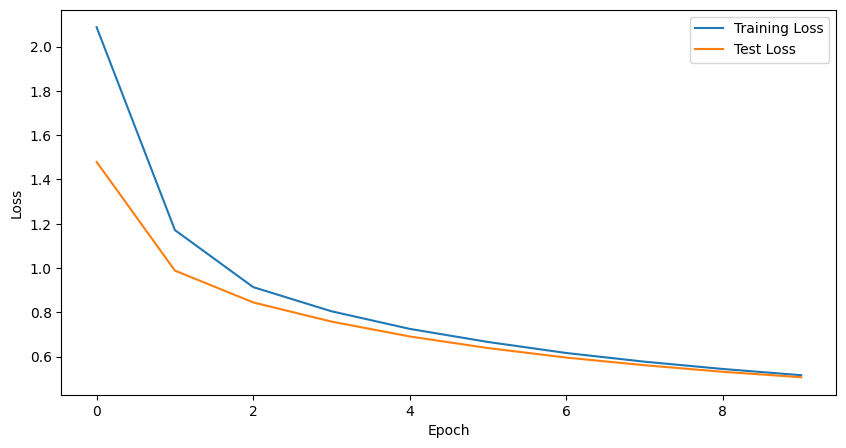

In [ ]:


# example solution code for Group 2:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load Boston Housing dataset
cali = fetch_california_housing()
X, y = cali.data, cali.target

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

# Normalize the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

# Define a batch size
batch_size = 64

# Create DataLoaders for training and testing data
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



class MyRegressor(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(MyRegressor, self).__init__()
        # Layer 1: 10 inputs -> 4, with sigmoid activation
        self.l1 = nn.Linear(n_input, n_hidden)

        # Layer 2: 4 inputs -> n_output, with softmax activation
        self.l2 = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        # Apply first layer and sigmoid activation
        x = torch.sigmoid(self.l1(x))
        return self.l2(x), self.l2(x)  # ugly workaround to make it compatible with earlier functions



n_input = x_train.shape[1]  # Number of features in the Boston Housing dataset
n_hidden = 4  # Example number of hidden units
n_output = 1  # Regression output

model = MyRegressor(n_input=n_input, n_hidden=n_hidden, n_output=n_output)

criterion = nn.MSELoss()  # For regression, Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    train_loss = train(model, trainloader, criterion, optimizer)
    test_loss = test(model, testloader, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(num_epochs), train_losses, label='Training Loss')
ax.plot(range(num_epochs), test_losses, label='Test Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc='upper right')
plt.show()

In [ ]:
rf = RandomForestRegressor()

# Train the random forest model
rf.fit(x_train, y_train[:,0])

# Predict on the test set
rf_predictions = rf.predict(x_test)

# Calculate the test loss (MSE)
rf_test_loss = mean_squared_error(y_test, rf_predictions)
print(f'Random Forest Test Loss: {rf_test_loss:.4f}')

Random Forest Test Loss: 0.2593
